<a href="https://colab.research.google.com/github/AlexeyTri/MyMachineLearningSeminars/blob/main/seminar7/%D0%9D%D0%B5%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Нелинейная регрессия. Обобщенные линейные модели. Нестандартная функция потерь**

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install samplesizelib

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

from samplesizelib.linear.statistical import LikelihoodRatioEstimator
from samplesizelib.linear.models import RegressionModel

from torchvision import datasets
from torchvision import transforms

# Нелинейная регрессия

## задача 1

выборка:

$𝔇 = \{x_i, y_i\}_{i=1}^l, x_i\in ℝ, y_i\in ℝ$

известно, что:

$y_i = f(x_i) \forall i \in 1...l$

$𝔉 = \{f:f(x,w) = w_0 + w_1x + w_2sin(x) + w_3cos(x), w\in ℝ^4\}$


как апроскимировать выборку $𝔇$?

!минимизация функционала

$L = \sum_{i=1}^{l}(f(x_i, w) - y_i)^2 \to min_w$



### вариант 1
исходное признаковое описание объектов $x_i$ отображаем в новое пространство признаков $x_i = \left[1, x_i, sin(x_i), cos(x_i)\right]$

решаем задачу линейное регрессии $y = w^{\top}x$

$\hat w$ - параметры модели $\hat f$

In [ ]:
np.random.seed(0)

l = 200
beta = 2

x = np.linspace(-10, 10, l)
w = np.array([1, 2, 3, 4])
y = w[0] + w[1]*(x)+ w[2] *np.sin(x) + w[3]*np.cos(x) + beta*np.random.randn(l)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=50)

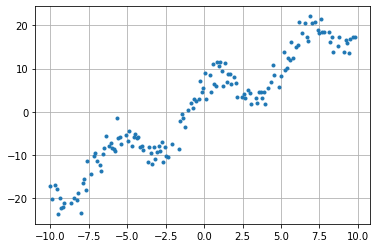

In [ ]:
plt.plot(x_train, y_train,'.')

plt.grid()
plt.show()

In [ ]:
def map_feature(x):
    return np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T

In [ ]:
X_train = map_feature(x_train)
X_test = map_feature(x_test)

In [ ]:
w_hat = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
w_hat

array([1.13720211, 1.97565739, 2.60619016, 4.18098566])

<ipython-input-9-7cff23db44e1>:8: MatplotlibDeprecationWarning: Unrecognized location 'beat'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='beat')


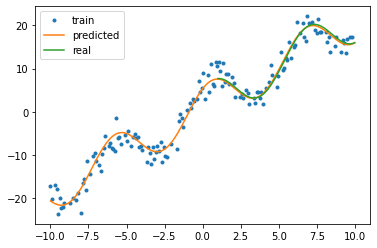

In [ ]:
plt.plot(x_train, y_train, '.', label='train')
x = np.linspace(-10, 10, 2000)
plt.plot(x, map_feature(x)@w_hat, label='predicted')

x = np.linspace(1-0,10,2000)
plt.plot(x, map_feature(x)@w, label='real')

plt.legend(loc='beat')
plt.show()

### вариант 2

ищем решение $\hat f$ в пространстве $𝔉$. Функция $\hat f$ полностью описывается своими параметрами $\hat w$. Найти $\hat w$:

1. градиентный спуск
2. метод Ньютона-Рафсона
3. метод Ньютона-Гаусса

In [ ]:
def f(w,x):
    X = np.vstack([np.ones_like(x), x , np.sin(x), np.cos(x)]).T
    return X@w

def d_f_d_w(w, x):
    return np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T

def d_L_d_w(w, x, y):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return 2*X.T@X@w - 2*X.T@y

def d_2_L_d_2_w(w, x, y):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T 
    return 2*X.T@X

#### градиентный спуск

$w_{t+1} = w_t - α\frac{\partial L}{\partial w}(w_t)$

In [ ]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    w_hat = w_hat - 0.0001*d_L_d_w(w_hat, x_train, y_train)
    list_of_w.append(w_hat)

list_of_w = np.array(list_of_w[:1000])

CPU times: user 354 ms, sys: 665 µs, total: 355 ms
Wall time: 358 ms


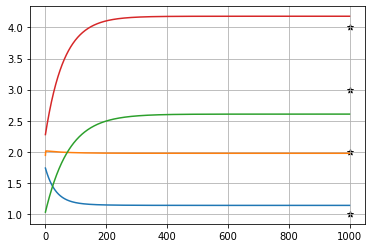

In [ ]:
_ = plt.plot(list_of_w)
plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')
plt.grid()

#### метод Ньютона-Рафсона

$w_{t+1} = w_t - α\left(\frac{\partial^2 L}{\partial w\partial w^{\top}}(w_t)\right)^{-1}\frac{\partial L}{\partial w}(w_t)$

In [ ]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    w_hat = w_hat - np.linalg.inv(d_2_L_d_2_w(w_hat, x_train, y_train))@d_L_d_w(w_hat,x_train, y_train)
    list_of_w.append(w_hat)

list_of_w = np.array(list_of_w[:500])

CPU times: user 1.32 s, sys: 1.26 s, total: 2.57 s
Wall time: 1.47 s


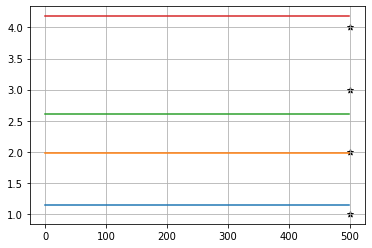

In [ ]:
_ = plt.plot(list_of_w)
plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')
plt.grid()

#### метод Ньютона-Гаусса

$w_{t+1} = w_t - α(F_t^{\top}F_t)^{-1}F_t^{\top}(f_t - y)$

$F_t = ||\frac{\partial f}{\partial w^j}(x_i, w_t)||_{i,j}$

$f_t = ||f(x_i, w_t)||_{i}$

In [ ]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    F_t = d_f_d_w(w_hat, x_train)
    w_hat = w_hat - np.linalg.inv(F_t.T@F_t)@F_t.T@(f(w_hat, x_train) - y_train)
    list_of_w.append(w_hat)

list_of_w = np.array(list_of_w[:500])

CPU times: user 1.19 s, sys: 1.08 s, total: 2.26 s
Wall time: 1.21 s


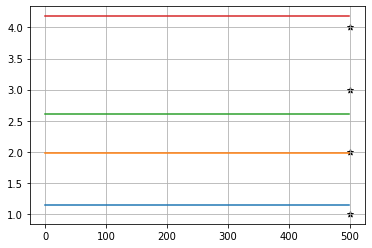

In [ ]:
_ = plt.plot(list_of_w)
plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')
plt.grid()
# сходится также мгновенно

## задача 2

выборка:

$𝔇 = \{x_i, y_i\}_{i=1}^l, x_i\in ℝ, y_i\in ℝ$

известно, что:

$y_i = f(x_i) \forall i \in 1...l$

$𝔉 = \{f:f(x,w) = exp(w_0x) + w_1sin(w_2x), w\in ℝ^3\}$


как апроскимировать выборку $𝔇$?

!минимизация функционала

$L = \sum_{i=1}^{l}(f(x_i, w) - y_i)^2 \to min_w$

In [ ]:
np.random.seed(0)
l  =200
beta = 0.2

x = np.linspace(-2, 2, l)
w = np.array([1, 2, 3])
y = np.exp(w[0]*x) + w[1]*np.sin(x*w[2]) + beta +np.random.randn(l)

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=50)

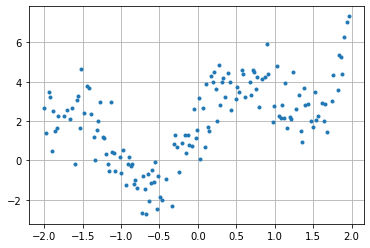

In [ ]:
plt.plot(x_train, y_train, '.')

plt.grid()
plt.show()

#### градиентный спуск

$w_{t+1} = w_t - α\frac{\partial L}{\partial w}(w_t)$

In [ ]:
def f (x,w):
    return torch.exp(w[0]*x) + w[1]*torch.sin(x*w[2])

In [ ]:
torch.manual_seed(0)
w_hat = torch.randn(3)
w_hat.requires_grad = True

X_tr = torch.FloatTensor(x_train)
y_tr = torch.FloatTensor(y_train)

loss_function = torch.nn.MSELoss()
optim =torch.optim.SGD([w_hat], lr=0.01 )

for i in tqdm(range(1, 1000), leave=False):
    optim.zero_grad()
    loss = loss_function(f(X_tr, w_hat), y_tr)
    loss.backward()

    optim.step()

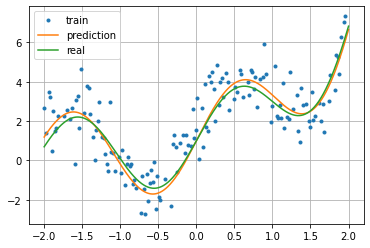

In [ ]:
plt.plot(x_train, y_train,'.', label='train')
x = np.linspace(-2,2, 2000)
plt.plot(x, f(torch.Tensor(x), w_hat).detach().cpu().numpy(), label='prediction')

x = np.linspace(-2,2,2000)
plt.plot(x, f(torch.Tensor(x), torch.tensor(w)).detach().cpu().numpy(), label='real')

plt.legend(loc='best')
plt.grid()
plt.show()

ОБОБЩЕННАЯ ЛИНЕЙНАЯМОДЕЛЬ
1. нормальное распределение - линейная регрессия
2. Бернулевское распределение - логистическая регрессия
3. Биномиальное распределение - многоклассовая регрессия


# Обобщенная линейная модель

пусть правдободобие имеет следующий вид:

$𝑝(y|θ,𝜙)=exp\left(\frac{yθ - b()θ}{a(𝜙)} + c(y,𝜙)\right)$

примеры распределений, плотность которых имеет данный вид:
1. нормальное распределение - линейная регрессия
2. биноминальное распределение - логистическая регрессия

## определение оптимального размера выборки для обобщенно линейных моделей

Рассмотрим пример для определения оптимального размера выборки для задачи линейной регресии:
во-первых нужно определить понятие оптимальности
во-вторых предложить метод

пример: тест отношения правдоподобия

Рассмотрим гипотезу
$H_0:m_u=m_u^0, H_1: m_u \ne m_u^0$

определим следующую статистику:

$LR = 2\left(l(\hat w)-l(\hat w^0)\right), l(w) = logL(w)=\sum_{i=1}^{l}log 𝑝(y_i|x_i,w)$
===

будем говорить, что объем выборки $l$ достаточный,если мы можем проверить нулевую гипотезу на уровне значимости $α$ и ошибки второго рода $β$

обозначим:
1. ответ из принципа максимального правдоподобия $\hat w = [\hat w_u, \hat w_v]$
2. ответ из принципа максимального правдоподобия $\hat w_0 = [\hat m_u, \hat w_u^0]$, при условии фиксируемой части вектора $m_u^0$

---
В случае истинности гипотезы $H_0$ статистика $LR$ ассимпотитечски имеет распределение 𝜒^2(k). В случае истинности гипотезы $H_1$ статистика $LR$ имеет распределение $𝜒^2(k,𝛾)$, где 𝛾 это параметр нецентральности, который выражается в следующем виде:
$𝛾 = lΔ^*, Δ=Ε[(2α^{-1}(𝛷)\{(𝛩-𝛩^*)∇b(𝛩) - b(𝛩) + b(𝛩^*)\}]$
===

$𝛩,𝛩^*$ вычисляются при помощи векторов $w = [w_u, w_v], w^* = [w_u^0, w_v^*]$
$w_v^*$ решением уравнения:
$\lim_{m\to ∞}l^{-1}Ε\left(\frac{\partial l([m_u^0, w_v])}{\partial w_v}\right) =0$
---
на основе параметров $α,β$ оптимальный размер выборки $l^*$ получается с решением уравнения:
$l^* = \frac{ℽ^*}{Δ^*}, ℽ^*:𝜒^2_{k,1-\alpha} = 𝜒^2_{k,β}(ℽ)$
===


$𝜒^2_{k,1-\alpha},𝜒^2_{k,β}(ℽ^*)$ квантили распределения $𝜒^2_kи 𝜒^2_k(ℽ^*)$

In [ ]:
data = dict()

for n in tqdm(range(2, 103, 10), leave=False):
    data[n] = dict()
    for l in range(300, 3000, 100):

        np.random.seed(0)
        X_rg = np.random.randn(l , n)
        w = np.random.randn(n)
        y_rg = X_rg@w + np.random.randn(l)*n / 20

        model = LikelihoodRatioEstimator(RegressionModel, **{'epsilon' : 0.1,
                                                             'alpha' : 0.05,
                                                             'beta' : 0.05})
        
        ret = model(X_rg, y_rg)

        data[n][l] = ret['m*']

  0%|          | 0/11 [00:00<?, ?it/s]

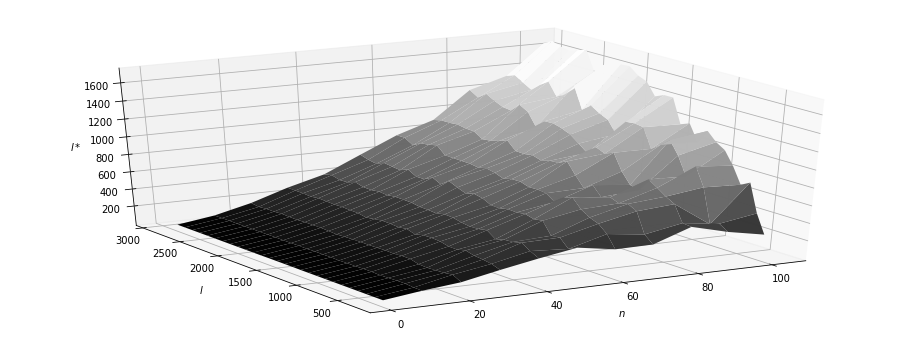

In [ ]:
ns, ls = np.meshgrid(list(data.keys()), list(data[2].keys()))
scores = np.zeros_like(ns)
for i in range(len(ns)):
    for j in range(len(ns[i])):
        scores[i][j] = data[ns[i][j]][ls[i][j]]

ax = plt.figure(figsize=(16,6)).gca(projection='3d')
ax.plot_surface(ns, ls, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$n$', labelpad=14), ax.set_ylabel(r'$l$', labelpad=14)
ax.set_zlabel(r'$l*$'), ax.view_init(30,-120)

plt.show()

# Нестандартные фунукции потерь

* построение эмбедингов
рассмотрим задачу построения некоторого представления об объектах для их дальнейшего сравнения.
Эмбединг - векторное представление объекта.
Рассмотрим задачу построения эмбедингов предложений:

$𝔇 = \{s_i, p_i, n_i\}_{i=1}^l$

$s_i$ - некоторое предложение

$p_i$ - множество индексов предложений, по смыслу близких к данному

$n_i$ - множество индексов предложений по смыслу далеких от данного


требуется построить отображение $f: S\to ℝ_n$ так чтобы выполнялись следующие условия:

$\sum_{i=1}^{l}\sum_{j\in p_i}||f(s_i)-f(s_j)||\to min$


$\sum_{i=1}^{l}\sum_{j\in n_i}||f(s_i)-f(s_j)||\to max$


* TripletLoss


$L(f) = \sum_{i=1}^{l}max\{0,\sum_{j\in p_i}||f(s_i)-f(s_j)|| - \sum_{j\in n_i}||f(s_i)-f(s_j)||+margin\} \to min_f$
===

$f$ - параметрическая функция, настройка параметров происходит при помощи градиентных методов

на каждом шаге генерится:
$l'$ - батч, состоящий из множества троек $(s_i, positive_i, negative_i)$

$s_i$ - одно предложение из выборки

$positive_i$ - одно предложение похожее на $s_i$

$negative_i$ - одно предложение не похожее на $s_i$

решаем следующую задачу оптимизации:

$L'(f) = \sum_{i=1}^{l}max\{0,\sum_{j\in p_i}||f(s_i)-f(positive_i)|| - \sum_{j\in n_i}||f(s_i)-f(negative_i)||+margin\} \to min_f$
===


In [5]:
model = SentenceTransformer('LaBSE')

sentences = ['hello world',
             'привет мир',
             'прощайте все',
             'сегодня лучший день в моей жизни',
             'сегодня худший день в моей жизни']

vects = model.encode(sentences)
d = cdist(vects, vects)

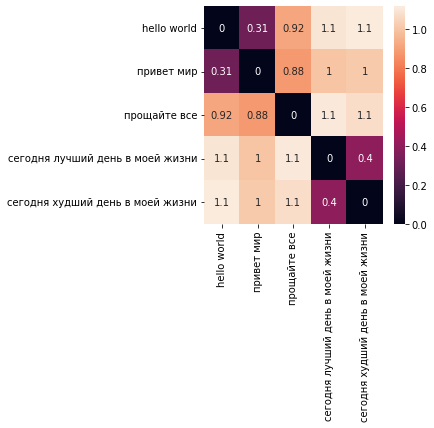

In [6]:
ax = plt.figure(figsize=(4,4)).gca()
sns.heatmap(d, xticklabels=sentences, yticklabels=sentences, ax=ax, annot=True)

plt.show()

# ⚡ SGD

In [8]:
from torch.utils.data import TensorDataset, Dataset
from torch import nn
from torch import optim
import math

In [15]:
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    compute the gradient of 'outputs' with respect to 'inputs'
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])    
    '''

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])

def jacobian(outputs, inputs, create_graph=False):    
    '''
    compute the jacobian of 'outputs' with respect to 'inputs'
    jacobian(x,x)
    jacobian(x * y, [x, y])
    jacobian([x * y, x.sqrt()], [x, y])    
    '''
    if torch.is_tensor(outputs):
        outputs = [outputs]
    else:
        outputs = list(outputs)
        
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    
    jac = []
    for output in outputs:
        output_flat = output.view(-1)
        output_grad = torch.zeros_like(output_flat)
        for i in range(len(output_flat)):
            output_grad[i] = 1
            jac += [gradient(output_flat, inputs,  output_grad, True, create_graph)]
            output_grad[i] = 0
    return torch.stack(jac)

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    compute the hessian of 'output' with respect to 'inputs'
    hessian((x * y).sum(), [x, y])    
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)
    
    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad
    return out

    

In [10]:
x = np.linspace(7, 20)
y = np.linspace(-1.0, 1.2)

def f(x, y):
    return 0.5*np.sin(x)/((x-6)**2)**0.1+y**2

def f_tensor(x):
    return 0.5*torch.sin(x[0])/((x[0]-6)**2)**0.1+x[1]**2

In [11]:
torch.manual_seed(9)
w = torch.Tensor([12.5, 1.15])
w.requires_grad = True
optim = torch.optim.SGD([w], lr=0.01)

list_of_w = []
list_of_w.append(w.detach().cpu().numpy().copy())


for i in tqdm(range(1, 2501), leave=False):
    optim.zero_grad()
    
    loss = f_tensor(w)
    loss.backward()
    w.grad += 1.5*torch.randn(2)
    
    optim.step()
    
    if i < 100 and i % 10 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    elif i % 100 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    
list_of_w_sgd = np.array(list_of_w)

In [16]:
torch.manual_seed(9)
w = torch.Tensor([12.5, 1.15])
w.requires_grad = True
optim = torch.optim.SGD([w], lr=0.01)

list_of_w = []
list_of_w.append(w.detach().cpu().numpy().copy())


for i in tqdm(range(1, 2501), leave=False):
    optim.zero_grad()
    
    hess = hessian(f_tensor(w), [w])
    optim.zero_grad()
    grad = gradient(f_tensor(w), [w])
    optim.zero_grad()
    
    w.grad = torch.inverse(hess)@grad
    
    optim.step()
    
    if i < 100 and i % 10 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    elif i % 100 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    
list_of_w_neuton = np.array(list_of_w)

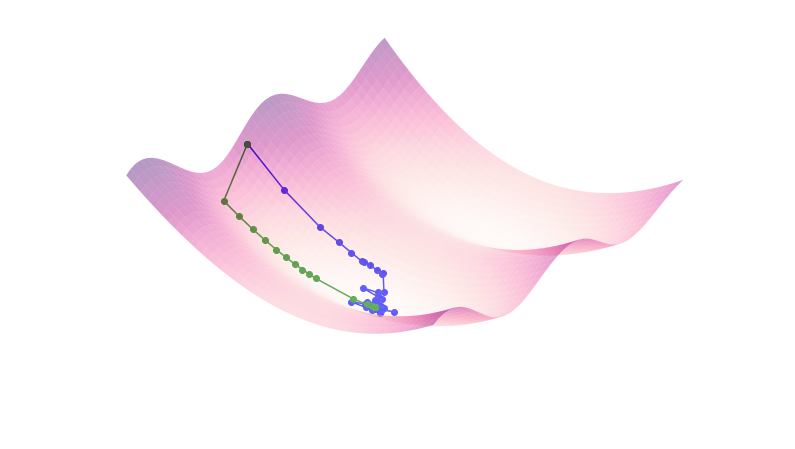

In [22]:
X, Y = np.meshgrid(x, y)
scores = f(X, Y)

ax = plt.figure(figsize=(14.0, 8.0)).gca(projection='3d')

ax.plot_surface(X, Y, scores, cmap='RdPu', alpha=0.4)
ax.plot(list_of_w_sgd[:,0], list_of_w_sgd[:,1], 
        f(list_of_w_sgd[:,0], list_of_w_sgd[:,1]), '-ob')
ax.plot(list_of_w_neuton[:,0], list_of_w_neuton[:,1], 
        f(list_of_w_neuton[:,0], list_of_w_neuton[:,1]), '-og')

ax.view_init(60, -140)

plt.axis('off')
plt.show()